In [1]:
# data management
import pandas as pd    
import numpy as np
import scipy

# data viz
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from matplotlib.collections import LineCollection
import missingno as msno
import nltk
import seaborn as sns

In [2]:
df = pd.read_csv('movie_metadata.csv')
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [3]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

# Les valeurs manquante

In [4]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Valeurs nulles', 1 : 'Valeurs manquantes', 2 : '% des valeurs totales'})
        mz_table['Total zéro valeurs manquantes'] = mz_table['Valeurs nulles'] + mz_table['Valeurs manquantes']
        mz_table['% Total zéro valeurs manquantes'] = 100 * mz_table['Total zéro valeurs manquantes'] / len(df)
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% des valeurs totales', ascending=False).round(1)
        print ("Le dataframe a " + str(df.shape[1]) + " colonne et " + str(df.shape[0]) + " Lignes.\n"     
            "Il y a " + str(mz_table.shape[0]) +
              " colonnes qui ont des valeurs manquantes.")
        return mz_table
pd.options.display.max_rows = 10
missing_zero_values_table(df)

Le dataframe a 28 colonne et 5043 Lignes.
Il y a 21 colonnes qui ont des valeurs manquantes.


,Valeurs nulles,Valeurs manquantes,% des valeurs totales,Total zéro valeurs manquantes,% Total zéro valeurs manquantes
gross,0,884,17.5,884,17.5
budget,0,492,9.8,492,9.8
aspect_ratio,0,329,6.5,329,6.5
content_rating,0,303,6.0,303,6.0
plot_keywords,0,153,3.0,153,3.0
...,...,...,...,...,...
actor_2_facebook_likes,55,13,0.3,68,1.3
language,0,12,0.2,12,0.2
actor_1_name,0,7,0.1,7,0.1
actor_1_facebook_likes,26,7,0.1,33,0.7


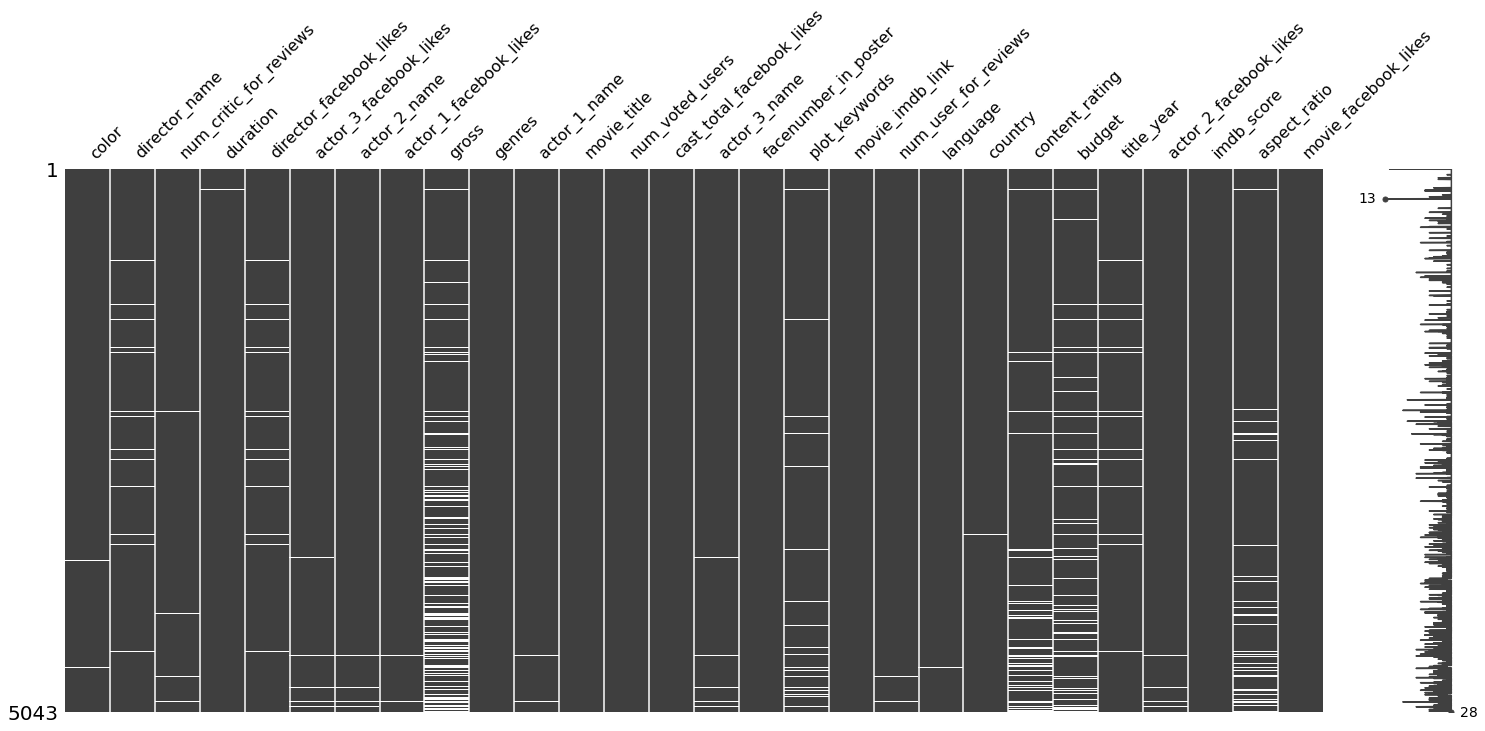

In [5]:
msno.matrix(df)

Text(0.5, 1.0, 'Proportion des colonnes avec des valeurs manquantes')

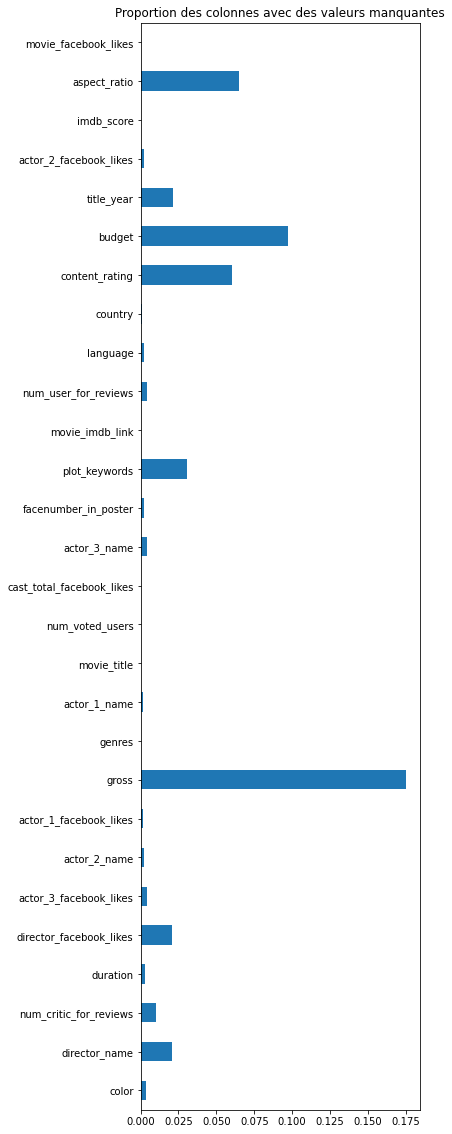

In [6]:
# Proportion des colonnes avec des valeurs manquantes
plt.figure(figsize=(5, 20))
df.isnull().mean(axis=0).plot.barh()
plt.title("Proportion des colonnes avec des valeurs manquantes")

# Traitement des valeurs manquantes

## Variable categorielles

Pour les variables catégorielles, je remplace les valeurs manquantes par des champs vides. Les valeurs de ces variables seront traitées ensuite comme des variables muettes et nous retirerons la variable correspondant au champ vide.

Je ne remplace pas les champs vides de la variable movie_title, car sans le nom du film, il est impossible de savoir à quel film cette ligne correspond.

In [7]:
df[['color']] = df[['color']].fillna('')
df[['director_name']] = df[['director_name']].fillna('')
df[['actor_2_name']] = df[['actor_2_name']].fillna('')
df[['genres']] = df[['genres']].fillna('')
df[['actor_1_name']] = df[['actor_1_name']].fillna('')
df[['actor_3_name']] = df[['actor_3_name']].fillna('')
df[['plot_keywords']] = df[['plot_keywords']].fillna('')
df[['movie_imdb_link']] = df[['movie_imdb_link']].fillna('')
df[['language']] = df[['language']].fillna('')
df[['country']] = df[['country']].fillna('')

## Variables numériques


J'ai choisi deux stratégies pour remplacer les valeurs manquantes des variables numériques :
Soit remplacer les valeurs manquantes par 0, soit remplacé les valeurs manquantes par la moyenne faite sur la variable.

Les variables dont les valeurs manquantes seront remplacées par 0 :

+ num_critic_for_reviews
+ director_facebook_likes
+ actor_3_facebook_likes
+ actor_1_facebook_likes
+ number_voted_users
+ cast_total_facebook_likes
+ face_number_in_poster
+ num_user_for_reviews
+ actor_2_facebook_likes
+ movie_facebook_likes


Les variables pour lesquelles je décide de calculer la moyenne faite sur la variable sont les variables pour lesquelles une valeur nulle paraît aberrante. Je préfère prendre la moyenne faite sur ces variables.

Les variables pour les valeurs manquantes seront remplacées par la moyenne :

+ duration
+ gross
+ budget
+ title_year
+ imdb_scores
+ aspect_ratio

In [8]:
#Remplacer les valeur NaN pour les variables :  num_critic_for_reviews, director_facebook_likes, actor_3_facebook_likes
#, actor_1_facebook_likes, number_voted_users, cast_total_facebook_likes, face_number_in_poster
#num_user_for_reviews, actor_2_facebook_likes, movie_facebook_likes par 0

df[['num_critic_for_reviews']] = df[['num_critic_for_reviews']].fillna(0)
df[['director_facebook_likes']] = df[['director_facebook_likes']].fillna(0)
df[['actor_3_facebook_likes']] = df[['actor_3_facebook_likes']].fillna(0)
df[['actor_1_facebook_likes']] = df[['actor_1_facebook_likes']].fillna(0)
df[['num_voted_users']] = df[['num_voted_users']].fillna(0)
df[['cast_total_facebook_likes']] = df[['cast_total_facebook_likes']].fillna(0)
df[['facenumber_in_poster']] = df[['facenumber_in_poster']].fillna(0)
df[['num_user_for_reviews']] = df[['num_user_for_reviews']].fillna(0)
df[['actor_2_facebook_likes']] = df[['actor_2_facebook_likes']].fillna(0)
df[['movie_facebook_likes']] = df[['movie_facebook_likes']].fillna(0)

#Remplacer les valeurs NaN pour les variables :  duration, gross, budget, title_year, imdb_scores, aspect_ratio par la moyenne
df[['duration']] = df[['duration']].fillna(0)
#df[['duration']] = df[['duration']].fillna(df[['duration']].mean())
df[['gross']] = df[['gross']].fillna(df[['gross']].mean())
df[['budget']] = df[['budget']].fillna(df[['budget']].mean())
df[['title_year']] = df[['title_year']].fillna(df[['title_year']].mean())
df[['imdb_score']] = df[['imdb_score']].fillna(df[['imdb_score']].mean())
df[['aspect_ratio']] = df[['aspect_ratio']].fillna(df[['aspect_ratio']].mean())

In [9]:
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,7.605058e+08,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,2.370000e+08,2009.000000,936.0,7.9,1.780000,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,3.094042e+08,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,3.000000e+08,2007.000000,5000.0,7.1,2.350000,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,2.000742e+08,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,2.450000e+08,2015.000000,393.0,6.8,2.350000,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,4.481306e+08,Action|Thriller,...,2701.0,English,USA,PG-13,2.500000e+08,2012.000000,23000.0,8.5,2.350000,164000
4,,Doug Walker,0.0,0.0,131.0,0.0,Rob Walker,131.0,4.846841e+07,Documentary,...,0.0,,,NaN,3.975262e+07,2002.470517,12.0,7.1,2.220403,0


# Analyse exploratoire

### Top 10 réalisateurs - score imdb

[Text(0, 0, ''),
 Text(0, 0, 'Clint Eastwood'),
 Text(0, 0, 'Martin Scorsese'),
 Text(0, 0, 'Renny Harlin'),
 Text(0, 0, 'Ridley Scott'),
 Text(0, 0, 'Spike Lee'),
 Text(0, 0, 'Steven Soderbergh'),
 Text(0, 0, 'Steven Spielberg'),
 Text(0, 0, 'Tim Burton'),
 Text(0, 0, 'Woody Allen')]

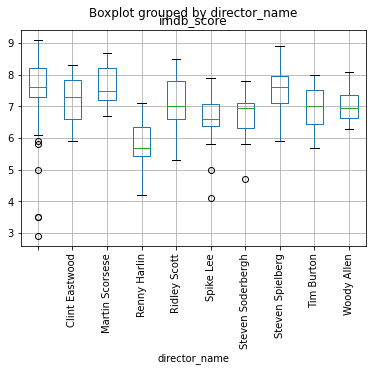

In [10]:
directors_IMDB = pd.concat([df[['director_name']], df[['imdb_score']]], axis=1)
x = directors_IMDB.groupby('director_name').count().nlargest(10, columns = 'imdb_score')
y = []
for i in x.index:
    y.append(directors_IMDB[i == directors_IMDB[['director_name']].values])

director_name_IMDBTopTen = pd.concat(y)
director_name_IMDBTopTen.boxplot(column='imdb_score', by='director_name')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

Martin Scorcese et Steven Spielberg sont les meilleurs producteurs de tous les films recensés sur le dataset.

### Top 10 acteurs - score imdb

[Text(0, 0, ''),
 Text(0, 0, 'Bill Murray'),
 Text(0, 0, 'Brad Pitt'),
 Text(0, 0, 'Bruce Willis'),
 Text(0, 0, 'Johnny Depp'),
 Text(0, 0, 'Liam Neeson'),
 Text(0, 0, 'Matt Damon'),
 Text(0, 0, 'Morgan Freeman'),
 Text(0, 0, 'Robert De Niro'),
 Text(0, 0, 'Steve Buscemi')]

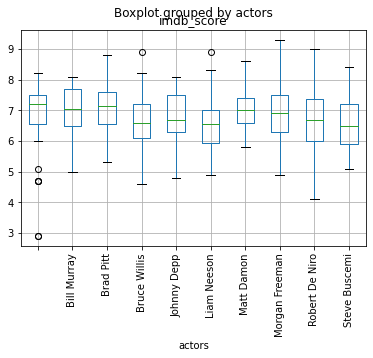

In [11]:
actor1 = df[['actor_1_name']].fillna('').values
actor2 = df[['actor_2_name']].fillna('').values
actor3 = df[['actor_3_name']].fillna('').values
actors = pd.DataFrame(np.concatenate((actor1, actor2, actor3), axis = 1), index = df.index, columns = ['actor_1_name','actor_2_name','actor_3_name'])
actors_ = actors.set_index(actors.index).stack().reset_index(level=1, drop=True).to_frame('actors'); 


genresIMDB = pd.concat([actors_, df[['imdb_score']]], axis=1)

x = genresIMDB.groupby('actors').count().nlargest(10, columns = 'imdb_score')
y = []
for i in x.index:
    y.append(genresIMDB[i == genresIMDB[['actors']].values])


genresIMDBTopTen = pd.concat(y)
genresIMDBTopTen.boxplot(column='imdb_score', by='actors')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Rassembler les 3 acteurs principaux dans une même colonne et supprimer les anciennes

In [12]:
actors = lambda row : [row["actor_1_name"],row["actor_2_name"],row["actor_3_name"]]
df["actors"] = df.apply(actors, axis = 1)

df.drop(columns=["actor_1_name","actor_2_name","actor_3_name"], inplace = True)

### Top 10 films - score imdb

In [13]:
top_film = df.sort_values(by='imdb_score', ascending=False)
top_film[['movie_title', 'imdb_score', 'director_name']].head(10)

,movie_title,imdb_score,director_name
2765,Towering Inferno,9.5,John Blanchard
1937,The Shawshank Redemption,9.3,Frank Darabont
3466,The Godfather,9.2,Francis Ford Coppola
4409,Kickboxer: Vengeance,9.1,John Stockwell
2824,Dekalog,9.1,
3207,Dekalog,9.1,
66,The Dark Knight,9.0,Christopher Nolan
2837,The Godfather: Part II,9.0,Francis Ford Coppola
3481,Fargo,9.0,
339,The Lord of the Rings: The Return of the King,8.9,Peter Jackson


In [14]:
# Supprimer films dupliqués

print("Nombre total de films: ", df.shape[0])
df = df.drop_duplicates(subset="movie_title")
print("Nombre de films sans les doublons: ", df.shape[0])

Nombre total de films:  5043
Nombre de films sans les doublons:  4917


In [15]:
top_film = df.sort_values(by='imdb_score', ascending=False)
top_film[['movie_title', 'imdb_score', 'director_name', 'duration']].head(10)

,movie_title,imdb_score,director_name,duration
2765,Towering Inferno,9.5,John Blanchard,65.0
1937,The Shawshank Redemption,9.3,Frank Darabont,142.0
3466,The Godfather,9.2,Francis Ford Coppola,175.0
4409,Kickboxer: Vengeance,9.1,John Stockwell,90.0
2824,Dekalog,9.1,,55.0
66,The Dark Knight,9.0,Christopher Nolan,152.0
2837,The Godfather: Part II,9.0,Francis Ford Coppola,220.0
3481,Fargo,9.0,,53.0
4822,12 Angry Men,8.9,Sidney Lumet,96.0
1874,Schindler's List,8.9,Steven Spielberg,185.0


### Analyse genres

In [16]:
set_keywords = set()

# Faire une liste des différents mots-clés dans les scénarios
for liste_keywords in df['plot_keywords'].str.split('|').values:
    
    if isinstance(liste_keywords, float): continue 
    set_keywords = set_keywords.union(liste_keywords)

    
def count_word(data, ref_col, liste): 
    ''' Comptez le nombre d'occurrences pour chaque mot-clé
    '''
    
    keyword_count = dict()
    
    for s in liste: keyword_count[s] = 0
        
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): 
            continue
            
        for s in [s for s in liste_keywords if s in liste]: 
            
            if pd.notnull(s):
                keyword_count[s] += 1
    
    # conversion de notre dictionnaire en liste
    keyword_occurences = []
    for k,v in keyword_count.items():
        
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    
    return keyword_occurences, keyword_count

keyword_occurences, dum = count_word(df, 'plot_keywords', set_keywords)
keyword_occurences[:10]

[['love', 191],
 ['friend', 164],
 ['murder', 157],
 ['', 152],
 ['death', 129],
 ['police', 125],
 ['new york city', 91],
 ['high school', 88],
 ['alien', 80],
 ['boy', 71]]

/System/Volumes/Data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Les genres les plus représentés parmi les films')

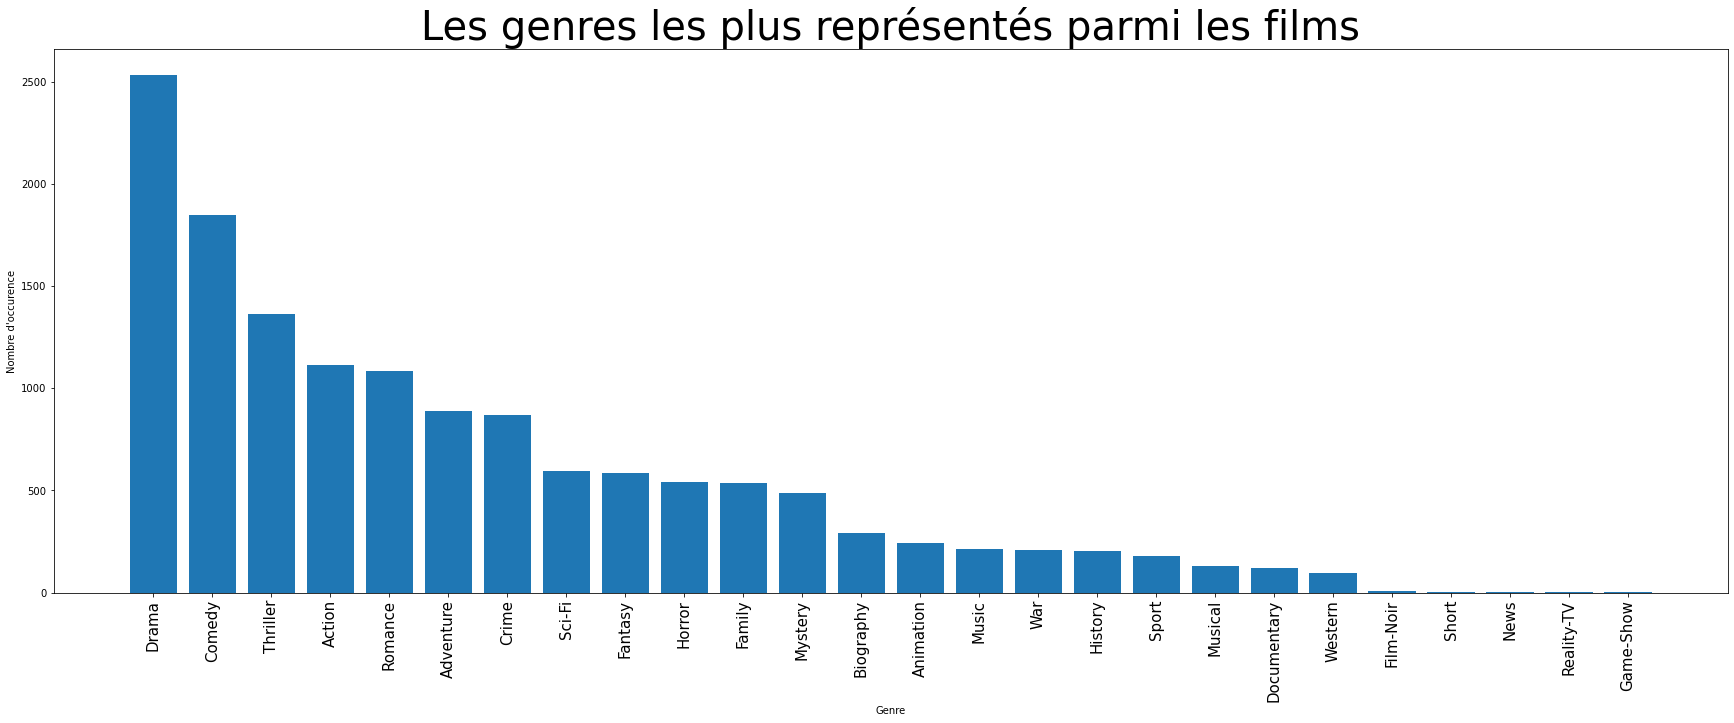

In [17]:
genre_labels = set()

for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences, dum = count_word(df, 'genres', genre_labels)

words = dict()
trunc_occurences = keyword_occurences[0:50]

for s in trunc_occurences:
    words[s[0]] = s[1]

# Graphique montrant les genres les plus présents dans les films

plt.figure(figsize=(30, 10))
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
label_x = [i[0] for i in trunc_occurences]
plt.xticks(rotation=90, fontsize = 15)
ax = plt.axes()
ax = ax.set(xlabel="Genre", ylabel="Nombre d'occurence")

plt.bar(label_x, y_axis)
plt.title("Les genres les plus représentés parmi les films",fontsize = 40)

In [18]:
print(genre_labels)

{'Reality-TV', 'Comedy', 'Animation', 'Drama', 'Sport', 'War', 'Mystery', 'Short', 'Family', 'Western', 'Action', 'News', 'Fantasy', 'Documentary', 'Romance', 'Music', 'Musical', 'Game-Show', 'Crime', 'Adventure', 'Film-Noir', 'Thriller', 'Sci-Fi', 'Horror', 'History', 'Biography'}


### Analyse age limite

In [19]:
df.groupby(['content_rating']).size()

content_rating
Approved     54
G           112
GP            6
M             5
NC-17         7
           ... 
TV-PG        13
TV-Y          1
TV-Y7         1
Unrated      59
X            12
Length: 18, dtype: int64

- TV-Y : Pour tous les enfants
- TV-Y7 : Pour les enfants de plus de 7 ans
- TV-G : pour tout le monde mais intéret à voir avec les parents
- TV-PG : peut contenir des choses particulière
- TV-14 : pour les plus de 14 ans
- TV-MA : pour adulte -- pour les plus de 17 ans
- G : tout public
- PG : peut heurter les jeunes
- PG-13 : pour les plus de 13
- NC-17 : pour les plus de 17 ans
- X : pour les plus de 17 ans
- R pour les plus de 17 ans
- GP pour tous : == PG
- M = PG


- Approved 54 -> on met en PG
- Not Rated 115 -> on met en NC-17
- Passed 9 -> G
- Unrated 59 -> NC-17


Je crée une nouvelle features : age_limite et je supprime la features content_rating
Pour les valeurs non renseignées, on met par défaut à 17 = 'R' pour éviter tout risque.

Je modifie toutes les valeurs de features par les valeurs correspondante ci-dessous.

In [20]:
dict_age_limite = {
    'TV-Y':0 ,
    'TV-Y7':7 ,
    'TV-G':0 ,
    'TV-PG':7, 
    'TV-14':14, 
    'TV-MA':17,
    'G':0, 
    'PG':7, 
    'PG-13':14, 
    'R': 17, 
    'NC-17': 17,
    'X': 17,
    'GP': 7, 
    'M': 7, 
    'Approved': 7, 
    'Not Rated': 17, 
    'Passed': 17, 
    'Unrated': 17    
}

In [22]:
df['age_limite'] = [lambda x: dict_age_limite[i] if type(i)!=float else 17 for i in df['content_rating']]

In [23]:
df['age_limite'] = df.apply(lambda x:[dict_age_limite[i] if type(i)!=float else 17 for i in df['content_rating']])

In [24]:
df.drop(columns=["content_rating"], inplace = True)

In [25]:
df

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,genres,movie_title,...,language,country,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,actors,age_limite
0,Color,James Cameron,723.0,178.0,0.0,855.0,1000.0,7.605058e+08,Action|Adventure|Fantasy|Sci-Fi,Avatar,...,English,USA,2.370000e+08,2009.000000,936.0,7.9,1.780000,33000,"[CCH Pounder, Joel David Moore, Wes Studi]",14
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,40000.0,3.094042e+08,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,...,English,USA,3.000000e+08,2007.000000,5000.0,7.1,2.350000,0,"[Johnny Depp, Orlando Bloom, Jack Davenport]",14
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,11000.0,2.000742e+08,Action|Adventure|Thriller,Spectre,...,English,UK,2.450000e+08,2015.000000,393.0,6.8,2.350000,85000,"[Christoph Waltz, Rory Kinnear, Stephanie Sigman]",14
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,27000.0,4.481306e+08,Action|Thriller,The Dark Knight Rises,...,English,USA,2.500000e+08,2012.000000,23000.0,8.5,2.350000,164000,"[Tom Hardy, Christian Bale, Joseph Gordon-Levitt]",14
4,,Doug Walker,0.0,0.0,131.0,0.0,131.0,4.846841e+07,Documentary,Star Wars: Episode VII - The Force Awakens ...,...,,,3.975262e+07,2002.470517,12.0,7.1,2.220403,0,"[Doug Walker, Rob Walker, ]",17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,637.0,4.846841e+07,Comedy|Drama,Signed Sealed Delivered,...,English,Canada,3.975262e+07,2013.000000,470.0,7.7,2.220403,84,"[Eric Mabius, Daphne Zuniga, Crystal Lowe]",17
5039,Color,,43.0,43.0,0.0,319.0,841.0,4.846841e+07,Crime|Drama|Mystery|Thriller,The Following,...,English,USA,3.975262e+07,2002.470517,593.0,7.5,16.000000,32000,"[Natalie Zea, Valorie Curry, Sam Underwood]",14
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,0.0,4.846841e+07,Drama|Horror|Thriller,A Plague So Pleasant,...,English,USA,1.400000e+03,2013.000000,0.0,6.3,2.220403,16,"[Eva Boehnke, Maxwell Moody, David Chandler]",17
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,946.0,1.044300e+04,Comedy|Drama|Romance,Shanghai Calling,...,English,USA,3.975262e+07,2012.000000,719.0,6.3,2.350000,660,"[Alan Ruck, Daniel Henney, Eliza Coupe]",14


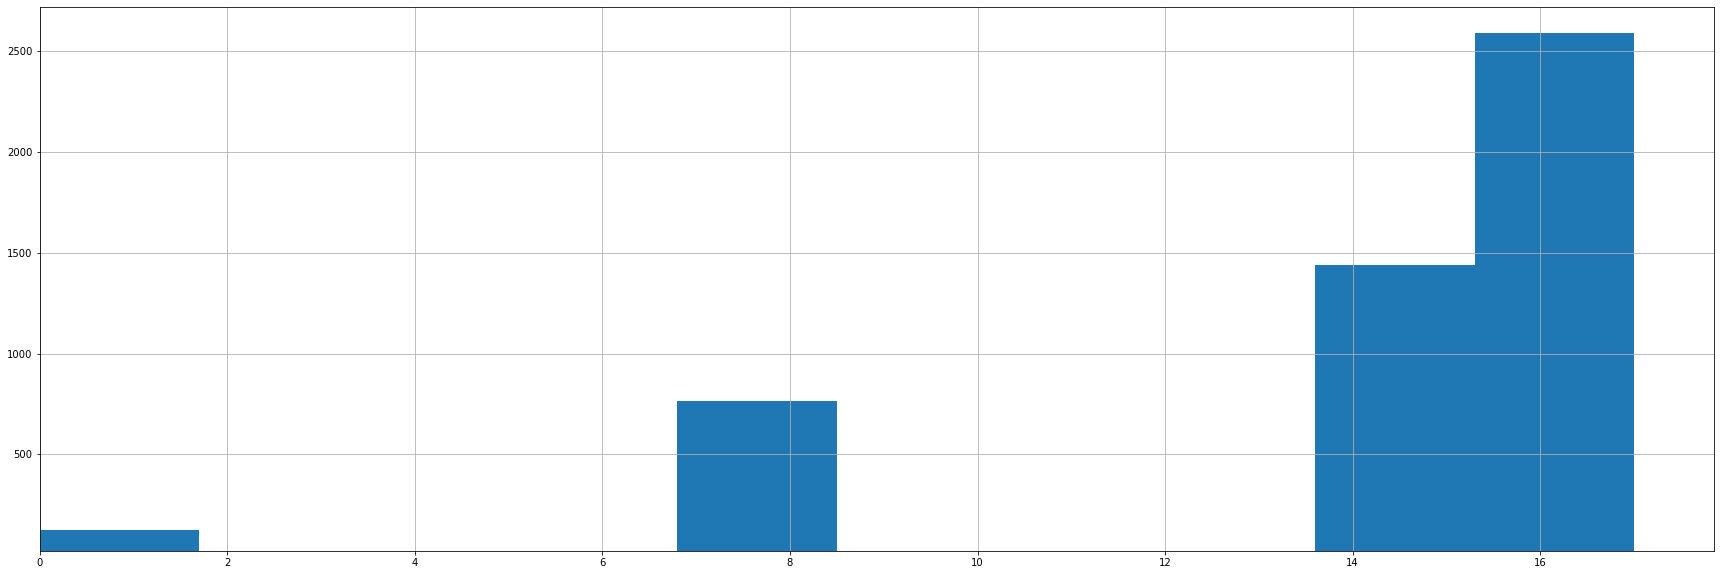

age_limite
0      123
7      765
14    1441
17    2588
dtype: int64

In [26]:
plt.figure(figsize=(30, 10))
u = df.age_limite
u.hist()
plt.xlim(0)
plt.ylim(22)
plt.show()

df.groupby(['age_limite']).size()

### Analyse budget

In [27]:
df.sort_values(by='budget', ascending=False).head(20)[['movie_title','budget','gross', 'title_year', 'country']]

,movie_title,budget,gross,title_year,country
3859,Lady Vengeance,4.200000e+09,211667.0,2005.0,South Korea
3005,Fateless,2.500000e+09,195888.0,2005.0,Hungary
2323,Princess Mononoke,2.400000e+09,2298191.0,1997.0,Japan
2334,Steamboy,2.127520e+09,410388.0,2004.0,Japan
3423,Akira,1.100000e+09,439162.0,1988.0,Japan
...,...,...,...,...,...
7,Tangled,2.600000e+08,200807262.0,2010.0,USA
6,Spider-Man 3,2.580000e+08,336530303.0,2007.0,USA
10,Batman v Superman: Dawn of Justice,2.500000e+08,330249062.0,2016.0,USA
27,Captain America: Civil War,2.500000e+08,407197282.0,2016.0,USA


Il y a plusieurs budgets anormaux. 

In [28]:
# On remplace les budget anormaux par la médiane
replace_budget = int(df.budget.median())
lst=df[df.budget>=300000000].iloc[1:].index
df.loc[lst, 'budget'] = replace_budget
print(len(lst), 'budgets anormaux remplacés par', replace_budget)

13 budgets anormaux remplacés par 23000000


[]

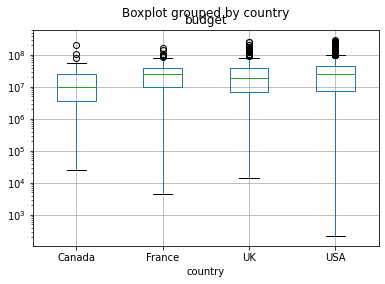

In [29]:
budgetUS = df[df[['country']].values == 'USA'][['budget','country']]
budgetFr = df[df[['country']].values == 'France'][['budget','country']]
budgetUk = df[df[['country']].values == 'UK'][['budget','country']]
budgetCanada = df[df[['country']].values == 'Canada'][['budget','country']]
y = pd.concat([budgetUS, budgetCanada, budgetFr, budgetUk], axis = 0)
y.boxplot(column='budget', by='country')
plt.semilogy()

Les films français ont a peu pres le meme budget que les USA

### Analyse pays

In [30]:
df.groupby('country').sum().sort_values('budget', ascending=False).head()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,age_limite
country,,,,,,,,,,,,,,,,,
USA,519926.0,394015.0,3019346.0,2654422.0,26821836.0,1.989863e+11,335737029,39921110,5284.0,1052010.0,1.319675e+11,7.429656e+06,6818789.0,23621.3,8178.758672,28940427,51827
UK,64635.0,47234.0,113246.0,207877.0,2458775.0,1.471022e+10,33119131,3476014,553.0,115198.0,1.240307e+10,8.686206e+05,543160.0,2951.3,996.029673,3313310,6077
France,20627.0,16777.0,48974.0,68622.0,656909.0,3.577879e+09,8043564,937052,179.0,29059.0,4.574427e+09,3.087509e+05,146894.0,1028.5,359.202821,758577,2311
Germany,12845.0,10360.0,27456.0,48885.0,567306.0,2.787753e+09,6904949,816433,136.0,27260.0,3.216778e+09,1.883160e+05,135600.0,593.7,202.570806,467922,1405
Canada,11388.0,12346.0,16340.0,28085.0,292946.0,4.135466e+09,3907226,416531,129.0,20646.0,2.277707e+09,2.486089e+05,52967.0,763.1,272.826449,329678,1879


Il y a deux pays non-valide 'Official site' et 'New Line'

In [31]:
# On remplace par la valeur la plus courante
replace = df.country.mode().values[0]
lst=df[df.country.isin(['Official site', 'New Line'])].index
df.loc[lst, 'country'] = replace
print(len(lst), 'country non valides remplacées par', replace)

2 country non valides remplacées par USA


### Analyse couleurs

Répartition avec grande majorité de Couleur

In [32]:
color = df.loc[df.color.isnull(),'color'] = 'Color'
df.loc[df['color']==' Black and White','color'] = 'Black and White'

In [33]:
# Analyse de la répartition Noir & Blanc / Couleur 
color = df[df.color.notnull()]
df.groupby(['color']).size()

color
                     19
Black and White     204
Color              4694
dtype: int64

Après analyse (il n'y a que 19 films dont la couleur n'est pas renseignée), je mets à Color les valeurs manquantes 

In [34]:
# Remplacement des valeurs non renseignée par Color 
df['color'].fillna('Color')

0       Color
1       Color
2       Color
3       Color
4            
        ...  
5038    Color
5039    Color
5040    Color
5041    Color
5042    Color
Name: color, Length: 4917, dtype: object

## Suppression des colonnes inutile

In [35]:
df_movie = df.drop(['movie_imdb_link', 
                    'aspect_ratio',
                    'facenumber_in_poster', 
                    'director_facebook_likes',
                    'actor_3_facebook_likes',
                    'actor_1_facebook_likes',
                    'num_critic_for_reviews',
                    'gross',
                    'cast_total_facebook_likes',
                    'num_voted_users',
                    'num_user_for_reviews',
                    'actor_2_facebook_likes',
                    'movie_facebook_likes',
                    'budget'],axis=1)

In [36]:
df_movie.head()

,color,director_name,duration,genres,movie_title,plot_keywords,language,country,title_year,imdb_score,actors,age_limite
0,Color,James Cameron,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,avatar|future|marine|native|paraplegic,English,USA,2009.000000,7.9,"[CCH Pounder, Joel David Moore, Wes Studi]",14
1,Color,Gore Verbinski,169.0,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,goddess|marriage ceremony|marriage proposal|pi...,English,USA,2007.000000,7.1,"[Johnny Depp, Orlando Bloom, Jack Davenport]",14
2,Color,Sam Mendes,148.0,Action|Adventure|Thriller,Spectre,bomb|espionage|sequel|spy|terrorist,English,UK,2015.000000,6.8,"[Christoph Waltz, Rory Kinnear, Stephanie Sigman]",14
3,Color,Christopher Nolan,164.0,Action|Thriller,The Dark Knight Rises,deception|imprisonment|lawlessness|police offi...,English,USA,2012.000000,8.5,"[Tom Hardy, Christian Bale, Joseph Gordon-Levitt]",14
4,,Doug Walker,0.0,Documentary,Star Wars: Episode VII - The Force Awakens ...,,,,2002.470517,7.1,"[Doug Walker, Rob Walker, ]",17


## Suppression des caractères d'espace 

In [37]:
def suppression_space_char(value):
    return value.replace(u'\xa0', u'')

df_movie['movie_title'] = [suppression_space_char(i) \
                            for i in df['movie_title']]

#df["movie_title"] = df["movie_title"].str.trim()

In [38]:
# Exporter le dataset

df_movie.to_csv('clean_data_films.csv',encoding='utf-8', index=False)